# **Richter's Predictor: Modeling Earthquake Damage - Model Selection**

In this notebook we will prepare our data for analysis and try different machine learning models for prediction. After indentifying the most promising models, those are optimized and results are interpreted with regards to our objective. The structure of the notebook follows this outline:
- Load modules
- Data preprocessing
- Model selection
- Model optimization
- Model summary

## Load modules

We load the necessary modules and packages.

In [77]:
# First we load all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import random
import time
import datetime

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from imblearn.combine import SMOTETomek

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import RFECV, RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn import svm 
import multiprocessing as mp
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

import statsmodels.formula.api as smf

from numpy import savetxt
from numpy import loadtxt
import pickle

import scipy.sparse
from pdpbox import pdp, get_dataset, info_plots

import matplotlib            
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#matplotlib.use('Qt5Agg')
%matplotlib inline

RSeed = 42
print(matplotlib.rcParams['backend'])

module://matplotlib_inline.backend_inline


## Import model data

First we import the cleaned up and engineered data from the previous steps.

In [84]:
#read in data
df = pd.read_pickle("data/model/data_model_complete.pkl")

## Select features for modeling

Then we split the data into features and target in order to perform a second train-test-split. The one we create now will serve as an evaluation set for model selection. We are about to try a range of machine learning models and let them compete for the best solution to our needs. Since we are looking for accessible insight from our machine learning models we are of course limited in a way but still have a wide variety to choose from. Next to our objective f1-score (combined with confusion matrices) we will have a look at the training times of our competitors. The training time is important because we are handeling a pretty large amount of data. Running this notebook with the full dataset takes a lot of time so we were incrementally increasing the amount of training data eliminating weaker models.  

In [87]:
#Split data into features and target
features = df.copy()
target = features.pop("damage_grade")

In [88]:
#drop features which are not needed for prediction
features_to_drop = ['district_id' ,"vdcmun_id" ,'structure_sum_gt_1', 'structure_sum_gt_3', 'structure_sum_ut_3', 
                    'ia_area_height_cat', 'age_log_cat', 'height_log_cat', 'area_log_cat',
                    'ia_area_height_ut_15k', 'ia_area_height_log_cat', 'superstructure_top30', 'superstructure_combination',
                    'structure_cat_weak', 'structure_cat_strong', 'structure_5cat_weak',
                    'structure_5cat_strong', 'ia_area_height', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq', 
                    'super_structure', 'secondary_use', 'secondary_use_combination']
features = features.drop(features_to_drop, axis=1)
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751356 entries, 0 to 751355
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   ward_id                                 751356 non-null  category
 1   legal_ownership_status                  751356 non-null  category
 2   count_families                          751356 non-null  float64 
 3   has_secondary_use                       751356 non-null  category
 4   has_secondary_use_agriculture           751356 non-null  category
 5   has_secondary_use_hotel                 751356 non-null  category
 6   has_secondary_use_rental                751356 non-null  category
 7   has_secondary_use_institution           751356 non-null  category
 8   has_secondary_use_school                751356 non-null  category
 9   has_secondary_use_industry              751356 non-null  category
 10  has_secondary_use_health_post   

## Train-Test-Split for model selection

In [89]:
# Split the 'features' and 'damage_grade' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.99, 
                                                    random_state=RSeed, 
                                                    shuffle=True, 
                                                    stratify=target)

# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 7513 samples.
Testing set has 743843 samples.


In [90]:
num_cols = list(features.columns[features.dtypes=='int64'])
num_cols += list(features.columns[features.dtypes=='float'])
cat_cols = list(features.columns[features.dtypes=='category'])
cat_cols.remove('ward_id')
print(len(cat_cols), 'categorical features +', len(num_cols), 'numerical features =',features.shape[1], 'features overall')

31 categorical features + 9 numerical features = 40 features overall


## Data Preprocessing

We still have some work to do before we can start with the calculations. From the summary above you may assume that the dataset is quite easy to manage. But converting it into meaningful and relevant information for our models takes serveral steps that increases the size of the data significantly. Here is a quick overview over those steps:
- Undersample the majortiy class (damage class 3) 
- OneHotEncode categorical data
- Scale, reduce and add polynomials and interactions for numerical data
- Recursive Feature Elimination in order to reduce the data to the most relevant information


We cut the data preparation pipeline down into single steps in order to get more feedback during the time consuming calculations. After all preprocessing steps we get back small summary that summarizes the most important results.

In [91]:
undersampler = OneSidedSelection(n_neighbors=2, n_seeds_S=150, n_jobs=-1, random_state=RSeed)

selector = RFE(DecisionTreeClassifier(min_samples_split=100, random_state=RSeed), step=0.1, verbose=10)

pca = PCA(random_state=RSeed)

polynom = PolynomialFeatures(degree=3, include_bias=False)

cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'),
])

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('reducer', pca),
    ('poly', polynom)
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder: 'passthrough')

"\npipe_sample = Pipeline(steps=[   \n    ('preprocessor', preprocessor),\n    ('sampler', sampler)\n])\n"

### Resampling

In [92]:
# Var of type object into category
obj_cols = list(X_train.columns[X_train.dtypes=='category'])
lst_dict = ["repl_" + i for i in obj_cols]
for i, col in enumerate(obj_cols):
    data = X_train[col].value_counts()
    dic = lst_dict[i] 
    dic = dict()
    for j in range(0, len(data)):
        dic[data.index[j]] = j + 1
    lst_dict[i] = dic
for i, col in enumerate(obj_cols):
    X_train[col] = X_train[col].replace(lst_dict[i])
    X_train[col] = pd.to_numeric(X_train[col])   

In [93]:
start = time.time()
X_train_rsm, y_train = undersampler.fit_resample(X_train, y_train)
end = time.time()
duration = end - start
print(duration)

0.35007548332214355


In [94]:
df[obj_cols] = df[obj_cols].astype('category')

### Preprocessing numerical and categorical features

In [95]:
start = time.time()
X_train_prep = preprocessor.fit_transform(X_train_rsm)
X_test_prep = preprocessor.transform(X_test)
X_eval_prep = preprocessor.transform(X_eval)
end = time.time()
duration = end - start
print(duration)

11.533713817596436


### Statistical Feature Selection

In [97]:
start = time.time()
X_train_sel = selector.fit_transform(X_train_prep, y_train)
X_test_sel = selector.transform(X_test_prep)
X_eval_sel = selector.transform(X_eval_prep)
end = time.time()
duration = end - start
print(duration)

Fitting estimator with 1222 features.
Fitting estimator with 1100 features.
Fitting estimator with 978 features.
Fitting estimator with 856 features.
Fitting estimator with 734 features.
Fitting estimator with 612 features.
22.458178758621216


In [98]:
print("After resampling, preprocessing, and recursive feature elimination the training dataset has "+
      str(X_train_sel.shape[0])+" rows and "+str(X_train_sel.shape[1])+" columns.\n"+
      "The training labels have "+str(y_train.shape[0])+" entries.\n"+
      "The test set includes "+str(X_test_sel.shape[0])+" rows and "+str(X_test_sel.shape[1])+" columns.")

After resampling, preprocessing, and recursive feature elimination the training dataset has 6089 rows and 611 columns.
The training labels have 6089 entries.
The test set includes 743843 rows and 611 columns.


## Model selection

Now that we prepared the data for the statistical models we will test different models. They all share a certain accessibility in one or another way. Speaking in broad terms we are applying models from two distinct families - tree based models and linear models. All models estimated with a minimum of parameters to get an idea about their unoptimized performance. We will optimize the most promising models in later steps. The next cells contain a lot of code but can be summarized with few bullet points:
- We define a list of models we want to test
- We define a function that returns detailed output about model performance
- We train all models defined earlier and keep track of results 

In [ ]:
# Define a list of models 
models = [
        DecisionTreeClassifier(min_samples_split=100, random_state=RSeed),
        RandomForestClassifier(n_estimators=500,max_depth=25, random_state=RSeed, n_jobs=-1),        
        xgb.XGBClassifier(random_state=RSeed, objective='multi:softprob',
                          eval_metric="auc", use_label_encoder=False,
                          n_jobs=-1),
        RidgeClassifier(max_iter=2000),
        LogisticRegression(max_iter=5000, n_jobs=-1, solver='saga')
         ]

model_name = ["DecisionTree", "RandomForest", "XGBoost", "RidgeRegression", "LogisticRegression"]

In [69]:
# Define a function that prints out a detailed model performance overview 
def print_scores(y_emp, y_pred):
    print('Averaged scores:')
    print('-------------------------')
    print('Accuracy: {:.2f}'.format(accuracy_score(y_emp, y_pred)))
    print('Recall (micro): {:.2f}'.format(recall_score(y_emp, y_pred, average='micro')))
    print('Precision (micro): {:.2f}'.format(precision_score(y_emp, y_pred, average='micro')))
    print('F1Score (micro): {:.2f}'.format(f1_score(y_emp, y_pred, average='micro')))
    print('')
    print('F1 scores per class:')
    print('-------------------------')
    for i, cl in enumerate(f1_score(y_emp, y_pred, average=None)):
        print('F1Score - Class {:d}: {:.2f}'.format(i,cl))
    cm = confusion_matrix(y_emp, y_pred)
    print('')
    print('Confusion matrix:')
    print('-------------------------')
    print(cm)

In [70]:
# Create lists for model results, train models in loop, and create results dataset
accuracy = []
recall = []
precision = []
f1 = []

accuracy_test = []
recall_test = []
precision_test = []
f1_test = []

time_train = []
time_predict_train = []
time_predict_test = []

k = len(models)

for i in range(k):
    start_fit = time.time()
    model = models[i].fit(X_train_sel, y_train)  
    end_fit = time.time()
    y_pred = models[i].predict(X_train_sel)
    end_predict_train = time.time()
    y_pred_test = models[i].predict(X_test_sel)
    end_predict_test = time.time()
    
    accuracy.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred, average='micro'))
    precision.append(precision_score(y_train, y_pred, average='micro'))
    f1.append(f1_score(y_train, y_pred, average='micro'))
    
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test, average='micro'))
    precision_test.append(precision_score(y_test, y_pred_test, average='micro'))
    f1_test.append(f1_score(y_test, y_pred_test, average='micro'))
    
    time_train.append(end_fit-start_fit) 
    time_predict_train.append(end_predict_train-end_fit)
    time_predict_test.append(end_predict_test-end_predict_train)
    
    print(f"Model {model_name[i]} done! Summary:\n")
    print_scores(y_test, y_pred_test)
    print('\n\n')
    
df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precision_train": precision,
                         "f1_train": f1,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precision_test": precision_test,
                         "f1_test": f1_test,
                         "time_train": time_train,
                         "time_predict_train": time_predict_train,
                         "time_predict_test": time_predict_test
                         })

Model DecisionTree done! Summary:

Averaged scores:
-------------------------
Accuracy: 0.60
Recall (micro): 0.60
Precision (micro): 0.60
F1Score (micro): 0.60

F1 scores per class:
-------------------------
F1Score - Class 0: 0.49
F1Score - Class 1: 0.17
F1Score - Class 2: 0.74

Confusion matrix:
-------------------------
[[ 61610  25773  74677]
 [ 13339  21022  98743]
 [ 14948  71865 361866]]



Model RandomForest done! Summary:

Averaged scores:
-------------------------
Accuracy: 0.66
Recall (micro): 0.66
Precision (micro): 0.66
F1Score (micro): 0.66

F1 scores per class:
-------------------------
F1Score - Class 0: 0.53
F1Score - Class 1: 0.13
F1Score - Class 2: 0.79

Confusion matrix:
-------------------------
[[ 68173  19100  74787]
 [ 13899  12126 107079]
 [ 12446  23601 412632]]



Model XGBoost done! Summary:

Averaged scores:
-------------------------
Accuracy: 0.63
Recall (micro): 0.63
Precision (micro): 0.63
F1Score (micro): 0.63

F1 scores per class:
---------------------

In [71]:
# Print results table
df_scores.sort_values("accuracy_test", ascending=False)

,name,accuracy_train,recall_train,precision_train,f1_train,accuracy_test,recall_test,precision_test,f1_test,time_train,time_predict_train,time_predict_test
1,RandomForest,0.982592,0.982592,0.982592,0.982592,0.662682,0.662682,0.662682,0.662682,5.783392,0.301308,24.161115
2,XGBoost,0.956315,0.956315,0.956315,0.956315,0.628824,0.628824,0.628824,0.628824,7.684336,0.017000,1.011738
4,LogisticRegression,0.704713,0.704713,0.704713,0.704713,0.619098,0.619098,0.619098,0.619098,88.769137,0.006002,0.673150
3,RidgeRegression,0.753326,0.753326,0.753326,0.753326,0.617805,0.617805,0.617805,0.617805,4.514675,0.009004,0.678184
0,DecisionTree,0.775333,0.775333,0.775333,0.775333,0.597570,0.597570,0.597570,0.597570,2.987189,0.008002,0.899910


We see that models deliver different results and pick the two most promising ones for further optimization. We take both leaders from the table above for 1) their accuracy and 2) their fast training speed. Both - Random Forest and XGBoost are tree based models that are well known for their fast calculation times and well performing algorithms. In gerneral, XGBoost should perform slighlty better with complex problems regarding our evalutaion metric, f1 score. 

## Plot model accuracy

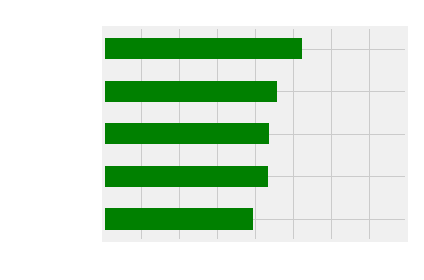

In [72]:
#ax = plt.Figure(figsize=(30,30))
plot1 = df_scores.sort_values("f1_test", ascending = True).plot(kind= "barh", x= "name", y = "accuracy_test", legend=None, color='green')
plt.xlim([0.4,0.8])
plot1.set_xlabel('F1 Score', fontsize = 16, c='white')
plot1.set_ylabel('', fontsize = 16, c='white')
plot1.set_title('Model Accuracy', fontsize = 20, c='white')
plot1.tick_params(colors='white', which='both')
#plot1.figure(figsize=(30,30))
plt.tight_layout()
plt.savefig('Figure_Selection_Model_Accuracy_1_per.png', transparent=True, bbox_inches='tight', dpi=200)

The results from our model selection run are summarized in the figure above.

# Model optimization

In order to get the best performance out of our models we need to optimize them and calibrate them to our current problem at hand. This task is done via Random Search which means we basically try different, random combinations from a list of predefinded model paramters in order to indentify the best working combination. 

## Random Forest

We start with the best one: Random Forest. Not only did the Random Forest perform best regarding accuracy metrics but also the training time was expectionally fast. 
In order to find the best paramters we use a RandomizedSearch over a predefined set of parameters.

In [73]:
rs_grid_rf = {
    'n_estimators': [100, 250, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': list(range(7,25))
    }

# Instantiate random search and define the metric to optimize 
rs_rf = RandomizedSearchCV(RandomForestClassifier(random_state = RSeed), rs_grid_rf, scoring='f1_micro',
                  cv=3, verbose=10, n_iter=10, random_state = RSeed, n_jobs=-1)


# Fit randomized search object to data
rs_rf.fit(X_train_sel, y_train) 

best_rf = rs_rf.best_estimator_
rs_rf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:   14.4s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:   15.8s remaining:   52.2s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   22.3s remaining:   38.6s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   26.2s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   31.0s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   34.8s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   35.6s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.4s finished


{'n_estimators': 500, 'min_samples_split': 16, 'max_depth': 5}

The random search returned the best parameter values for the Random Forest model. We will now use this knowledge to train a final model and add this to our model selection dataset. The cell below defines a function that allows us to repeat this step later.

In [74]:
def add_run(model_name, model, X_train=X_train, y_train=y_train, X_test=X_test):    
    model_name=str(model_name)
    start_fit = time.time()
    model = model.fit(X_train, y_train)  
    end_fit = time.time()
    y_pred = model.predict(X_train)
    end_predict_train = time.time()
    y_pred_test = model.predict(X_test)
    end_predict_test = time.time()
    
    time_sum = round(end_predict_test - start_fit, 0)
    
    accuracy=(accuracy_score(y_train, y_pred))
    recall=(recall_score(y_train, y_pred, average='micro'))
    precision=(precision_score(y_train, y_pred, average='micro'))
    f1=(f1_score(y_train, y_pred, average='micro'))
    
    accuracy_test=(accuracy_score(y_test, y_pred_test))
    recall_test=(recall_score(y_test, y_pred_test, average='micro'))
    precision_test=(precision_score(y_test, y_pred_test, average='micro'))
    f1_test=(f1_score(y_test, y_pred_test, average='micro'))
    
    time_train=(end_fit-start_fit) 
    time_predict_train=(end_predict_train-end_fit)
    time_predict_test=(end_predict_test-end_predict_train)

    print("Run successful after "+str(datetime.timedelta(seconds=time_sum))+" hours.\n\n"+
         "SUMMARY:\n\n")
    print_scores(y_test, y_pred_test)
    return [model_name,accuracy,recall,precision,f1,
                accuracy_test,recall_test,precision_test, f1_test,
                time_train, time_predict_train, time_predict_test]

In [75]:
df_scores.loc[len(df_scores)] = add_run("Random_Forest_RS", best_rf, X_train_sel, y_train, X_test_sel)

Run successful after 0:01:43 hours.

SUMMARY:


Averaged scores:
-------------------------
Accuracy: 0.69
Recall (micro): 0.69
Precision (micro): 0.69
F1Score (micro): 0.69

F1 scores per class:
-------------------------
F1Score - Class 0: 0.57
F1Score - Class 1: 0.00
F1Score - Class 2: 0.80

Confusion matrix:
-------------------------
[[ 73530    245  88285]
 [ 14419    108 118577]
 [  9440     99 439140]]


We increased the accuracy from the first run and move on with the second model.

In [78]:
filename = 'RF_finalized_model.sav'
pickle.dump(best_rf, open(filename, 'wb'))

Finally, we save the best Random Forest for later use.

## XGBoost

Let us continue with XGBoost. In order to find the best paramters we use a RandomizedSearch over a predefined set of parameters like we did with the Random Forest.

In [100]:
rs_grid_xgb = {
    'n_estimators': [100, 250, 500, 1000],
    'max_depth': list(range(3,15)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree"]
    }

# Instantiate random search and define the metric to optimize 
rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state=RSeed, objective='multi:softprob', eval_metric="auc", use_label_encoder=False), 
                            rs_grid_xgb, scoring='f1_micro', cv=3, verbose=10, n_jobs=-1, n_iter=10, random_state = RSeed)

# Fit randomized search object to data
rs_xgb.fit(X_train_sel, y_train)

best_xgb = rs_xgb.best_estimator_
rs_xgb.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:  2.2min remaining: 20.1min
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:  2.9min remaining:  9.6min
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:  4.5min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  4.8min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  7.3min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  8.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  8.5min remaining:   56.9s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.6min finished


[14:13:09] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "evals" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




As we now found the best parameters for model training we will use those for a final training run which is stored with the previous results.

In [101]:
df_scores.loc[len(df_scores)] = add_run("XGBoost_RS", best_xgb, X_train_sel, y_train, X_test_sel)
df_scores.to_csv('table_model_selection_1_per.csv')

[14:15:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "early_stopping_rounds", "evals" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Run successful after 0:00:58 hours.

SUMMARY:


Averaged scores:
-------------------------
Accuracy: 0.65
Recall (micro): 0.65
Precision (micro): 0.65
F1Score (micro): 0.65

F1 scores per class:
-------------------------
F1Score - Class 0: 0.51
F1Score - Class 1: 0.14
F1Score - Class 2: 0.78

Confusion matrix:
-------------------------
[[ 64964  19642  77454]
 [ 14430  14228 104446]
 [ 15334  31545 401800]]


We save the final model for later use.

In [102]:
filename = 'XGB_finalized_model.sav'
pickle.dump(best_xgb, open(filename, 'wb'))

The graphic below shows how model optimization positively affected our model scores. The increase in accuracy is in the range of single percentage points.  

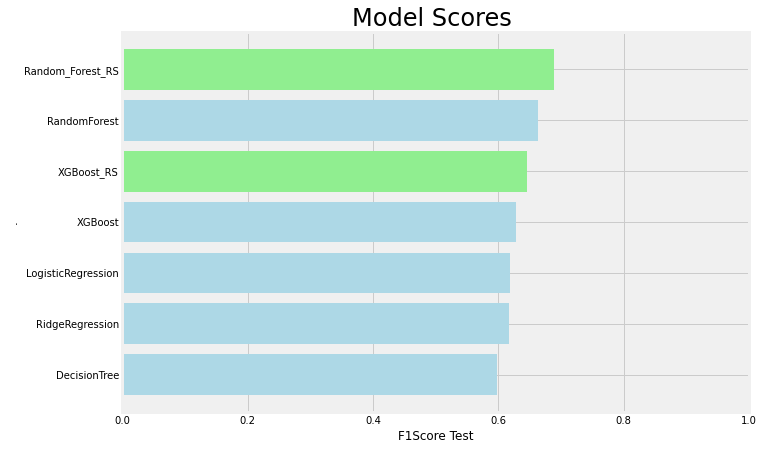

In [106]:
df_scores.sort_values("accuracy_test", ascending = True , inplace= True)

fig, ax = plt.subplots(figsize = (10,7))

color_list = ["lightblue"] * len(df_scores["name"].to_list())

color_list[-1] = "lightgreen"
color_list[-3] = "lightgreen"
#color_list[-4] = "lightgreen"

hbars = ax.barh(df_scores["name"], df_scores["accuracy_test"], align='center', color =color_list)

plt.xlim([0,1])

ax.set_xlabel('F1Score Test', fontsize = 12)
ax.set_ylabel('.')
ax.set_title('Model Scores ', fontsize = 24)

plt.savefig('Models_accuracy.png', transparent=True, bbox_inches='tight', dpi=200)

# Model exploration

Finally, in order to find an answer to our question which features are most important in order to migitate earthquake damage on buildings, we will check the feature importance from both our models. 

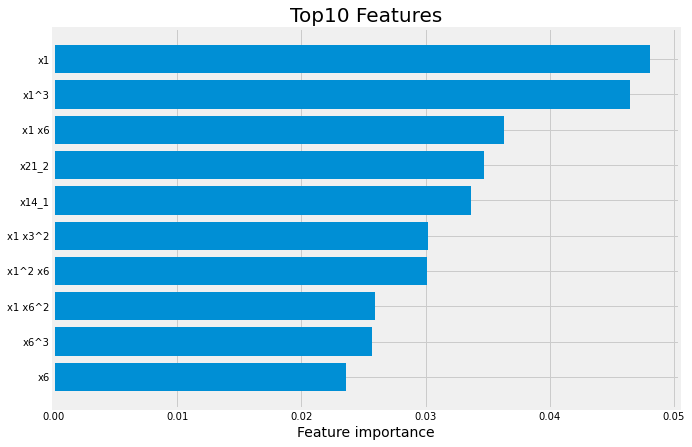

In [105]:
standard_scaler = preprocessor.named_transformers_["num"]['poly']
standard_scaler_names = standard_scaler.get_feature_names()
column_names = list(standard_scaler_names)

hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names()
column_names += list(hot_encoder_names)

column_names = np.array(column_names).reshape(1,-1)
column_names = selector.transform(column_names)
column_names = column_names.tolist()[0]

importance = list(best_rf.feature_importances_)

fig, ax = plt.subplots(figsize = (10,7))

df_importance = pd.DataFrame({"Feature": column_names, "Importance": importance})
df_importance.sort_values("Importance", ascending = True, inplace = True)

ax.barh(df_importance["Feature"].tail(10), df_importance["Importance"].tail(10))

ax.set_xlabel('Feature importance', fontsize = 14)
ax.set_ylabel('', fontsize = 12)
ax.set_title('Top10 Features', fontsize = 20)

plt.savefig('Feature_importance_RF_1per.png', transparent=True, bbox_inches='tight', dpi=200)

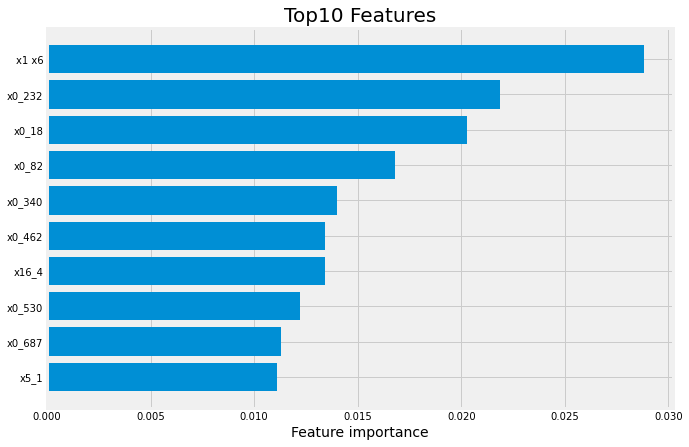

In [107]:
standard_scaler = preprocessor.named_transformers_["num"]['poly']
standard_scaler_names = standard_scaler.get_feature_names()
column_names = list(standard_scaler_names)

hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names()
column_names += list(hot_encoder_names)

column_names = np.array(column_names).reshape(1,-1)
column_names = selector.transform(column_names)
column_names = column_names.tolist()[0]

importance = list(best_xgb.feature_importances_)

fig, ax = plt.subplots(figsize = (10,7))

df_importance = pd.DataFrame({"Feature": column_names, "Importance": importance})
df_importance.sort_values("Importance", ascending = True, inplace = True)

ax.barh(df_importance["Feature"].tail(10), df_importance["Importance"].tail(10))

ax.set_xlabel('Feature importance', fontsize = 14)
ax.set_ylabel('', fontsize = 12)
ax.set_title('Top10 Features', fontsize = 20)

plt.savefig('Feature_importance_XGB_1per.png', transparent=True, bbox_inches='tight', dpi=200)

***Summary:*** 
- According to our RandomForest Model especially building attributes like height and size of the building are important
- According to our XGBoost Model overall the regional area in which the building is located matters more while the most important feature is in accordance with our Random Forest results (building attributes) 

From the bar graphs above we can see that the features and attributes of buildings have different importances when predicting the grade of damage. We will refrain from diving too deep into our results as we think it is wise to wait for the results from the complete models. But with regards to our initial objective we paved the way for gernerating the insight we hoped to find in the data. We plan to update our final summary as soon as we get back the final calculations. We will then also have a look at in which direction our features are affecting building damage. 